## ML Approach



In [1]:
import cv2
import numpy as np
from IPython.display import display
from PIL import Image

In [2]:
def contour_length(contour):
    total_length = 0.0
    for i in range(len(contour) - 1):
        # Extract coordinates of consecutive points
        x1, y1 = contour[i][0]
        x2, y2 = contour[i + 1][0]
        
        # Calculate the distance betwenn two points
        distance = np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
        
        # Add distance to total length
        total_length += distance
    
    # If the contour is closed, also add the distance between the last and first points.
    if len(contour) > 2 and np.all(contour[0] == contour[-1]):
        x1, y1 = contour[-1][0]
        x2, y2 = contour[0][0]
        total_length += np.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
    
    return total_length

In [3]:
def contours_length_path(image_path, gauss_kernel=3, threshold_area=50, tolerance=0):

    image = cv2.imread(image_path)
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Segment the blue lines 
    lower_blue = np.array([90, 50, 70])
    upper_blue = np.array([128, 255, 255])
    blue_mask = cv2.inRange(hsv, lower_blue, upper_blue)
    blue_segmented = cv2.bitwise_and(image, image, mask=blue_mask)

    # Detecting the contours of blue lines
    gray_blue = cv2.cvtColor(blue_segmented, cv2.COLOR_BGR2GRAY)
    blurred_image = cv2.GaussianBlur(gray_blue, (gauss_kernel, gauss_kernel), 0)
    contours_blue, _ = cv2.findContours(blurred_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    filtered_contours = [contour for contour in contours_blue if cv2.contourArea(contour) > threshold_area]
    # Calculate the total length path of all contours
    contours_lengths = [contour_length(contour) for contour in filtered_contours]
    total_length = sum(contours_lengths)

    # Draw contours on the original image
    drawn_contours_image = image.copy()
    cv2.drawContours(drawn_contours_image, filtered_contours[:], -1, (0, 255, 0), 2)    # Grenn for the bleu lines
    return total_length, drawn_contours_image

Image: ../AI-Lab_Traveling-Salesman-Problem/tsp-cv/38.jpg
Contours total length: 11142.257136297721


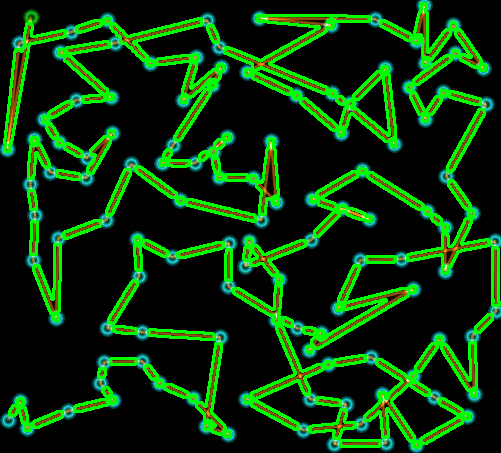

Image: ../AI-Lab_Traveling-Salesman-Problem/tsp-cv/0.jpg
Contours total length: 6952.681958742105


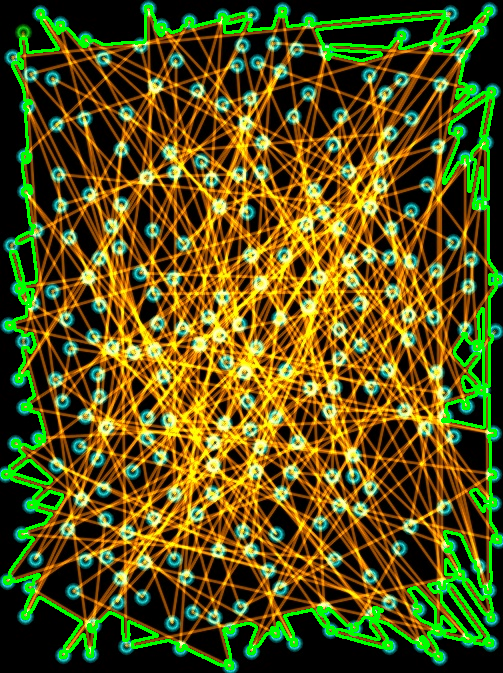

Image: ../AI-Lab_Traveling-Salesman-Problem/tsp-cv/80.jpg
Contours total length: 7236.835421122907


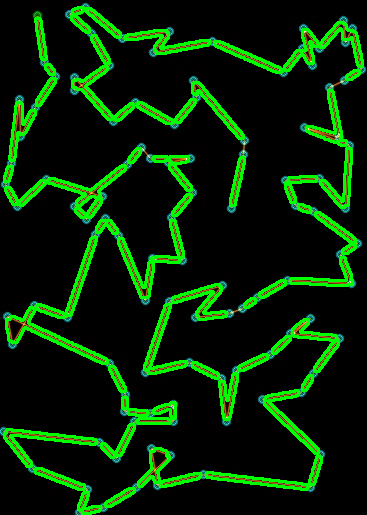

In [4]:
# Example usage:
images = ['../AI-Lab_Traveling-Salesman-Problem/tsp-cv/38.jpg', '../AI-Lab_Traveling-Salesman-Problem/tsp-cv/0.jpg', '../AI-Lab_Traveling-Salesman-Problem/tsp-cv/80.jpg']

for image in images:
    total_length, drawn_contours_image = contours_length_path(image, gauss_kernel=5)
    print(f"Image: {image}")
    print(f"Contours total length: {total_length}")
    display(Image.fromarray(drawn_contours_image))

In [73]:
import pandas as pd

In [16]:
# Function to create the initial DataFrame
def create_initial_dataframe(data_frame, image_folder, gauss_kernel):
    initial_data = []
    for filename in data_frame['filename']:
        image_path = f"{image_folder}/{filename}"
        contours_length, _ = contours_length_path(image_path, gauss_kernel)
        img = Image.open(image_path)
        width, height = img.size
        initial_data.append({
            'image_path': image_path,
            'contours_length': contours_length,
            'width': width,
            'height': height
        })
    return pd.DataFrame(initial_data)

In [18]:
# Example usage:
data = pd.read_csv('../AI-Lab_Traveling-Salesman-Problem/tsp-cv/train.csv')
image_folder = '../AI-Lab_Traveling-Salesman-Problem/tsp-cv'
gauss_kernel = 5

In [20]:
# Create the initial DataFrame
initial_df = create_initial_dataframe(data, image_folder, gauss_kernel)
initial_df.head(10)

,image_path,contours_length,width,height
0,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/0.jpg,6952.681959,503,673
1,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/1.jpg,2033.550432,906,222
2,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/2.jpg,39035.265417,810,999
3,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/3.jpg,26352.110519,781,717
4,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/4.jpg,23990.343925,609,884
5,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/5.jpg,15670.899198,621,533
6,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/6.jpg,2854.851081,406,334
7,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/7.jpg,37803.427756,880,911
8,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/8.jpg,23932.994503,868,529
9,../AI-Lab_Traveling-Salesman-Problem/tsp-cv/9.jpg,10079.858075,398,602


In [21]:
data['feature'] = initial_df['contours_length']
data['scale_factor'] = data['feature']/data['distance']

data.head(30)

# Save the new DataFrame
data.to_csv('train_with_features.csv', index=False)

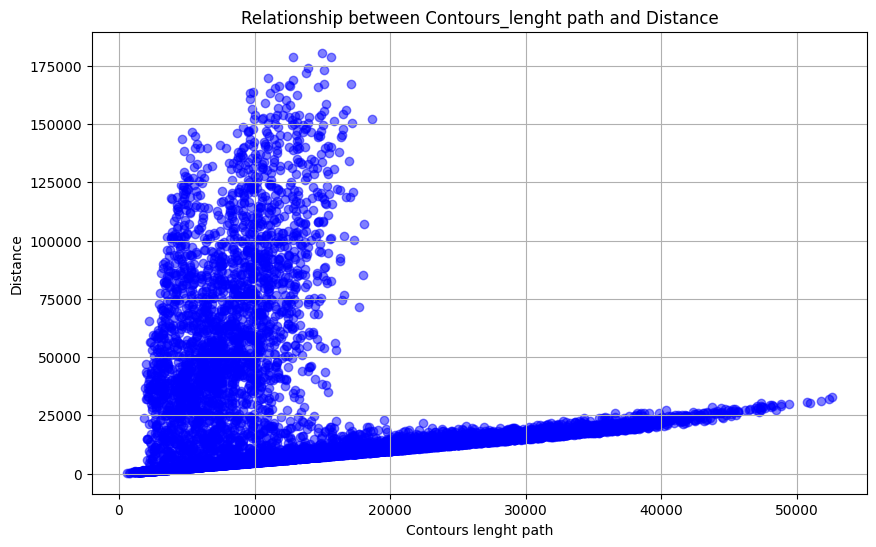

In [78]:
import matplotlib.pyplot as plt

# Assuming X_train and y_train are already defined and appropriate for plotting
plt.figure(figsize=(10, 6))
plt.scatter(data['feature'], data['distance'], color='blue', alpha=0.5)  # Plot as a scatter plot
plt.title('Relationship between Contours_lenght path and Distance')
plt.xlabel('Contours lenght path')
plt.ylabel('Distance')
plt.grid(True)
plt.show()

In [9]:
import cv2
import numpy as np
import pandas as pd

def additional_features(image_path):
    # Lire l'image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read the image at path: {image_path}")
        
    # Convertir en niveau de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Détecter les contours
    contours, _ = cv2.findContours(gray, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # Longueur totale des contours
        total_length = sum(cv2.arcLength(contour, True) for contour in contours)
        
        # Intensité moyenne
        mean_intensity = np.mean([cv2.mean(cv2.drawContours(np.zeros_like(image), [contour], -1, 255, cv2.FILLED))[:3] for contour in contours])
        
        # Canaux de couleur moyens
        red_channel = np.mean([cv2.mean(image[contour[:,0][:,1], contour[:,0][:,0]], mask=None)[2] for contour in contours])
        green_channel = np.mean([cv2.mean(image[contour[:,0][:,1], contour[:,0][:,0]], mask=None)[1] for contour in contours])
        blue_channel = np.mean([cv2.mean(image[contour[:,0][:,1], contour[:,0][:,0]], mask=None)[0] for contour in contours])
    else:
        total_length = 0
        mean_intensity = 0
        red_channel = 0
        green_channel = 0
        blue_channel = 0

    return {
        'total_length': total_length,
        'mean_intensity': mean_intensity,
        'red_channel': red_channel,
        'green_channel': green_channel,
        'blue_channel': blue_channel
    }



In [10]:
# Example usage:
data = pd.read_csv('../AI-Lab_Traveling-Salesman-Problem/tsp-cv/train.csv')

image_folder = '../AI-Lab_Traveling-Salesman-Problem/tsp-cv/'

additional_data = []
for filename in data['filename']:
    image_path = f"{image_folder}/{filename}"
    try:
        features = additional_features(image_path)
        additional_data.append(features)
    except ValueError as e:
        print(e)

additional_df = pd.DataFrame(additional_data)
print(additional_df)

       total_length  mean_intensity  red_channel  green_channel  blue_channel
0       7766.854691        0.333690          0.0            0.0      0.915433
1       6418.160047        0.036187          0.0            0.0      0.871002
2      19047.396004        0.100924          0.0            0.0      0.887780
3      14025.458389        0.152517          0.0            0.0      0.873505
4      15185.008807        0.146869          0.0            0.0      0.921333
...             ...             ...          ...            ...           ...
16013  12037.568997        0.012111          0.0            0.0      0.911630
16014  20040.679399        0.099195          0.0            0.0      0.905322
16015   9356.262973        0.013928          0.0            0.0      0.893914
16016  17589.429286        0.120741          0.0            0.0      0.873620
16017  10062.384900        0.091709          0.0            0.0      0.845785

[16018 rows x 5 columns]


In [11]:
# Save the additional features to a CSV file
#additional_df.to_csv('additional_features.csv', index=False)

In [25]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Loading data
data1 = pd.read_csv('feature1.csv')
data2 = pd.read_csv('feature2.csv')

feature1 = data1['feature'].values.reshape(-1, 1)
feature2 = data2['features'].values.reshape(-1, 1)
# Concatenate feature columns
X = np.concatenate((feature1, feature2), axis=1)
y = data1['distance']
print(X.shape, y.shape)

# Separation of data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

(16018, 2) (16018,)


In [26]:
import matplotlib.pyplot as plt

def plot_predictions_vs_actuals(y_test, y_pred):
    # Create a DataFrame from test data
    df = pd.DataFrame({
        'Actual': y_test,
        'Predicted': y_pred
    }) 

    # Select a few examples to plot
    sample_df = df.sample(n=10, random_state=42)  # Select 10 random examples

    # Sort the index to make the plot easier to understand
    sample_df = sample_df.sort_index()

    # Plotting
    sample_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Comparison of Actual vs. Predicted Values')
    plt.xlabel('Sample instances')
    plt.ylabel('Distance')
    plt.grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')
    plt.show()


### Random Forest model

In [27]:
# Random Forest model
rf = RandomForestRegressor()
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
print(f'Random Forest RMSE: {mean_squared_error(y_test, y_pred_rf, squared=False)}')
print(f'Random Forest R^2: {r2_score(y_test, y_pred_rf)}')

Random Forest RMSE: 24360.65824188776
Random Forest R^2: 0.041503586678716786


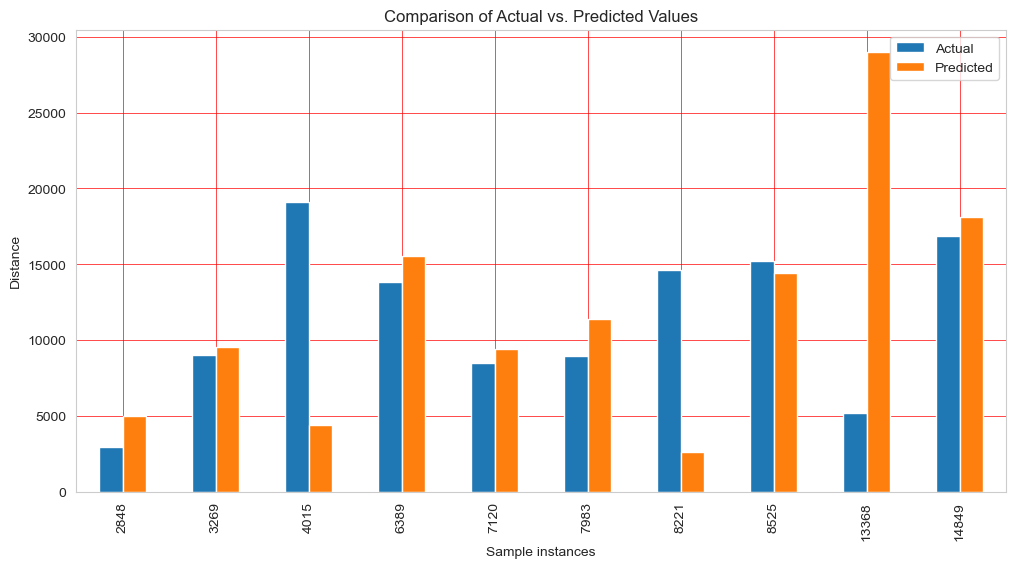

In [28]:
plot_predictions_vs_actuals(y_test, y_pred_rf)

In [29]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
print(f'CV RMSE: {np.sqrt(-cv_scores).mean()}')

CV RMSE: 25346.43069825099


In [30]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_
print(f'Best Random Forest RMSE: {mean_squared_error(y_test, best_rf.predict(X_test), squared=False)}')
print(f'Best Random Forest R^2: {r2_score(y_test, best_rf.predict(X_test))}')

Best Random Forest RMSE: 22854.269268498436
Best Random Forest R^2: 0.15637948200963958


In [39]:
print(f'Best Random Forest parameters: {grid_search.best_params_}')

Best Random Forest parameters: {'max_depth': 10, 'min_samples_split': 10, 'n_estimators': 200}


In [31]:
y_pred_best_rf = best_rf.predict(X_test)

### Gradient Boosting Model

In [32]:
# Gradient Boosting Model
gbm = GradientBoostingRegressor()
gbm.fit(X_train_scaled, y_train)
y_pred_gbm = gbm.predict(X_test_scaled)
print(f'Gradient Boosting RMSE: {mean_squared_error(y_test, y_pred_gbm, squared=False)}')
print(f'Gradient Boosting R^2: {r2_score(y_test, y_pred_gbm)}')

Gradient Boosting RMSE: 22997.06534032472
Gradient Boosting R^2: 0.14580447422080667


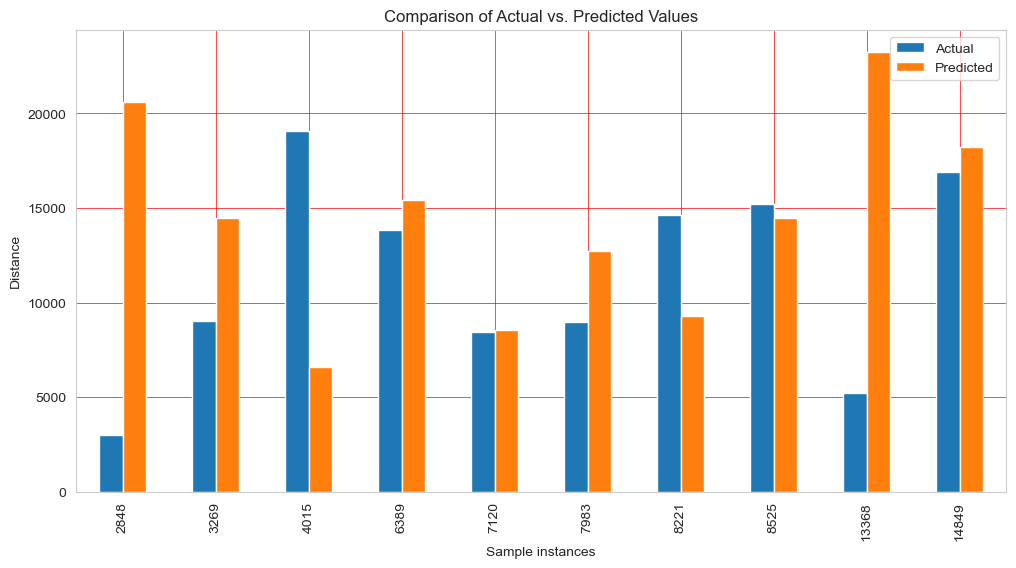

In [33]:
plot_predictions_vs_actuals(y_test, y_pred_gbm)

### Neural Network Model

In [34]:
mlp = MLPRegressor(max_iter=500)
mlp.fit(X_train, y_train)
y_pred_mlp = mlp.predict(X_test)
print(f'MLP RMSE: {mean_squared_error(y_test, y_pred_mlp, squared=False)}')
print(f'MLP R^2: {r2_score(y_test, y_pred_mlp)}')

MLP RMSE: 26597.072654972977
MLP R^2: -0.14256294008449966


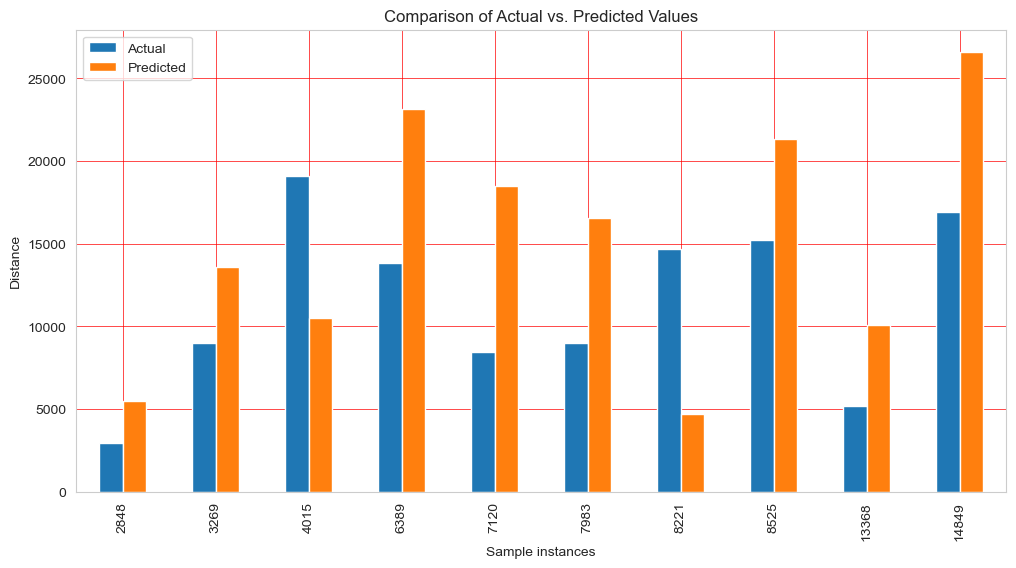

In [35]:
plot_predictions_vs_actuals(y_test, y_pred_mlp)

In [15]:
from sklearn.ensemble import VotingRegressor

voting_regressor = VotingRegressor(estimators=[
    ('rf', rf),
    ('gbm', gbm),
    ('mlp', mlp)
])

voting_regressor.fit(X_train, y_train)
y_pred_voting = voting_regressor.predict(X_test)
print(f'Voting Regressor RMSE: {mean_squared_error(y_test, y_pred_voting, squared=False)}')
print(f'Voting Regressor R^2: {r2_score(y_test, y_pred_voting)}')

Voting Regressor RMSE: 23349.119924957682
Voting Regressor R^2: 0.1194510864965983


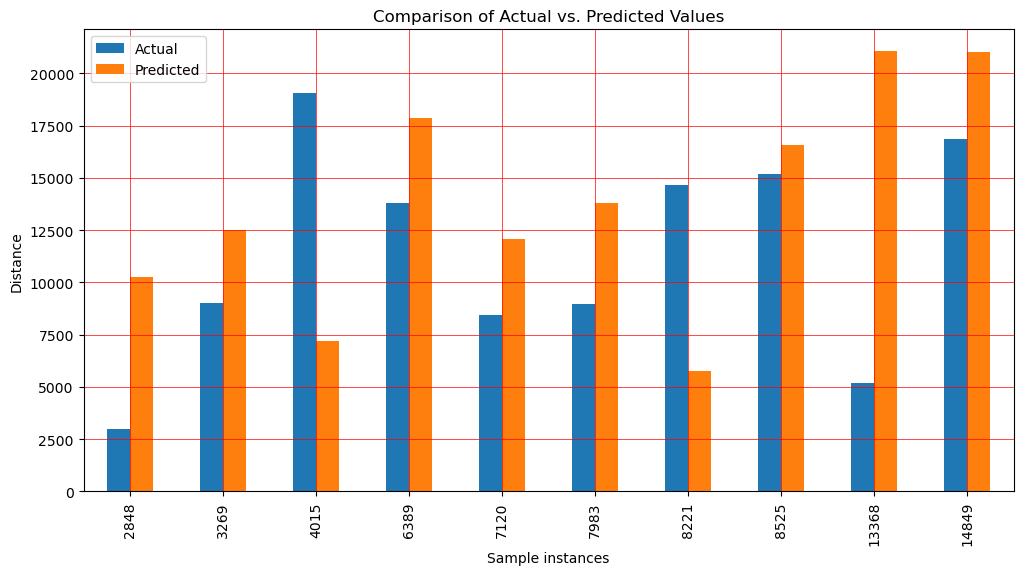

In [16]:
plot_predictions_vs_actuals(y_test, y_pred_voting)

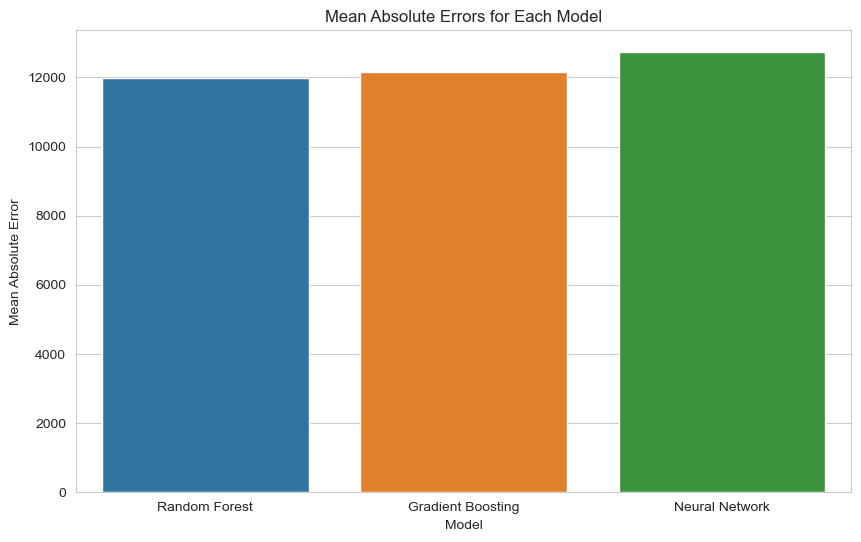

In [36]:
def plot_absolute_errors(y_test, y_pred_rf, y_pred_gbm, y_pred_nn):
    abs_errors = pd.DataFrame({
        'Random Forest': abs(y_pred_rf - y_test),
        'Gradient Boosting': abs(y_pred_gbm - y_test),
        'Neural Network': abs(y_pred_nn - y_test)
    })
    
    mean_abs_errors = abs_errors.mean().reset_index()
    mean_abs_errors.columns = ['Model', 'Mean Absolute Error']
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Model', y='Mean Absolute Error', data=mean_abs_errors)
    plt.title('Mean Absolute Errors for Each Model')
    plt.ylabel('Mean Absolute Error')
    plt.xlabel('Model')
    plt.show()

# Appel de la fonction avec vos données
plot_absolute_errors(y_test, y_pred_rf, y_pred_gbm, y_pred_mlp)


## Error Distribution over all model 

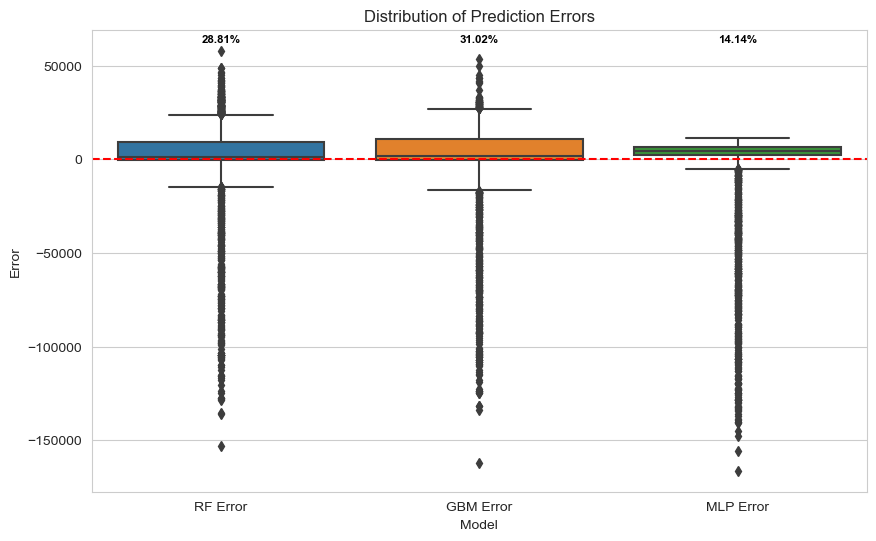

In [37]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_prediction_errors(y_test, y_pred_rf, y_pred_gbm, y_pred_mlp):
    errors = pd.DataFrame({
        'RF Error': y_pred_rf - y_test,
        'GBM Error': y_pred_gbm - y_test,
        'MLP Error': y_pred_mlp - y_test,
    })
    
    errors_melted = pd.melt(errors, var_name='Model', value_name='Error')
    
    plt.figure(figsize=(10, 6))
    boxplot = sns.boxplot(x='Model', y='Error', data=errors_melted)
    plt.axhline(0, color='r', linestyle='--')
    plt.title('Distribution of Prediction Errors')
    plt.ylabel('Error')
    plt.xlabel('Model')
    
    # Calculate the percentage of outliers for each model
    outlier_percentages = {}
    for model in errors.columns:
        q1 = errors[model].quantile(0.25)
        q3 = errors[model].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = errors[(errors[model] < lower_bound) | (errors[model] > upper_bound)]
        outlier_percentage = len(outliers) / len(errors) * 100
        outlier_percentages[model] = outlier_percentage
    
    # Add outlier percentages to the plot
    for i, model in enumerate(errors.columns):
        num_outliers = len(errors[(errors[model] < lower_bound) | (errors[model] > upper_bound)])
        outlier_percentage = num_outliers / len(errors) * 100
        x = i
        y = boxplot.get_ylim()[1] * 0.9  
        plt.text(x, y, f'{outlier_percentage:.2f}%', horizontalalignment='center', size='small', color='black', weight='semibold')
    
    plt.show()

# Appel de la fonction avec vos données
plot_prediction_errors(y_test, y_pred_best_rf, y_pred_gbm, y_pred_mlp)

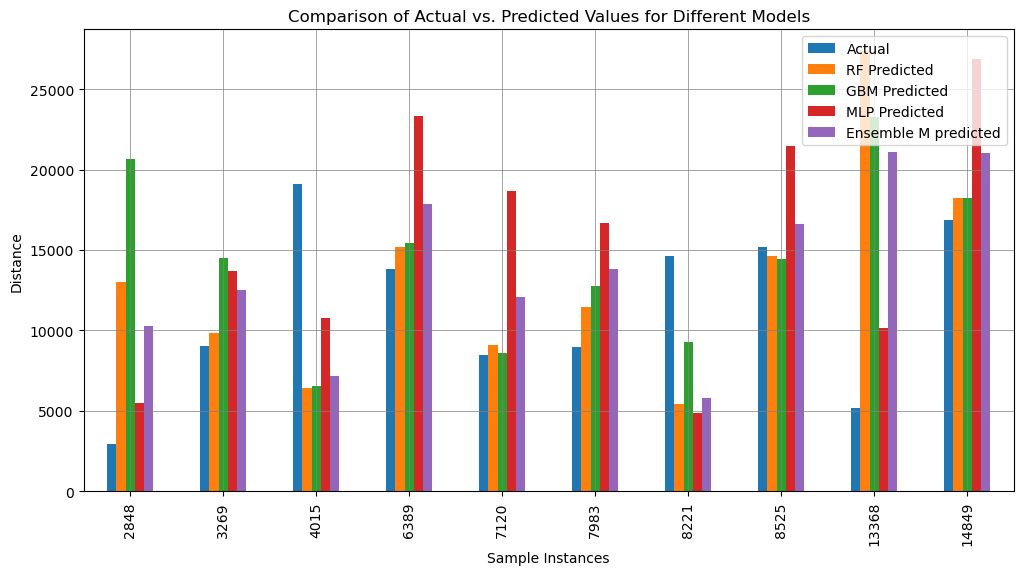

In [34]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_predictions_vs_actuals(y_test, y_pred_rf, y_pred_gbm, y_pred_nn, y_pred_voting):
    # Create a DataFrame from test data and predictions
    df = pd.DataFrame({
        'Actual': y_test,
        'RF Predicted': y_pred_rf,
        'GBM Predicted': y_pred_gbm,
        'NN Predicted': y_pred_nn,
        'Voting Predicted': y_pred_voting
    }) 

    # Select a few examples to plot
    sample_df = df.sample(n=10, random_state=42)  # Select 10 random examples

    # Sort the index to make the plot easier to understand
    sample_df = sample_df.sort_index()

    # Plotting
    ax = sample_df.plot(kind='bar', figsize=(12, 6))
    plt.title('Comparison of Actual vs. Predicted Values for Different Models')
    plt.xlabel('Sample Instances')
    plt.ylabel('Distance')
    plt.grid(which='both', linestyle='-', linewidth='0.5', color='gray')
    #plt.grid(which='major', linestyle='-', linewidth='0.5', color='red')

    # Adding custom legend
    plt.legend(['Actual', 'RF Predicted', 'GBM Predicted', 'MLP Predicted', 'Ensemble M predicted'], loc='upper right')
    
    plt.show()

# Example call to the function with your data
plot_predictions_vs_actuals(y_test, y_pred_best_rf, y_pred_gbm, y_pred_mlp, y_pred_voting)